In [1]:
%run utils.ipynb
%run transformers.ipynb

In [2]:
df=pd.read_csv("../data/train.csv")

#drop some useless columns
cols_to_drop=["Id","PID"]
df=df.drop(columns=cols_to_drop)

df_copy=df.copy()

### The target label

In [3]:
df['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

Sale Price is non-zero and non-negative. So that is good.

Skew: 1.56


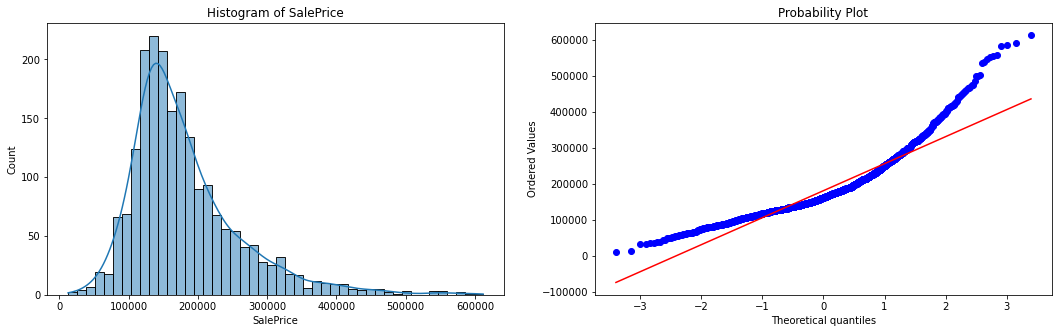

In [4]:
show_hist_qq(df,"SalePrice","Histogram of SalePrice")

This looks heavily right skewed and not normal distributed.  
Skew = 1.56. For a normal distribution, skew $\approx$ 0.  
This one has a moderate positive skew.  
Let's try to log this value.

In [5]:
df=log_and_return(df,"SalePrice")

Skew: -0.15


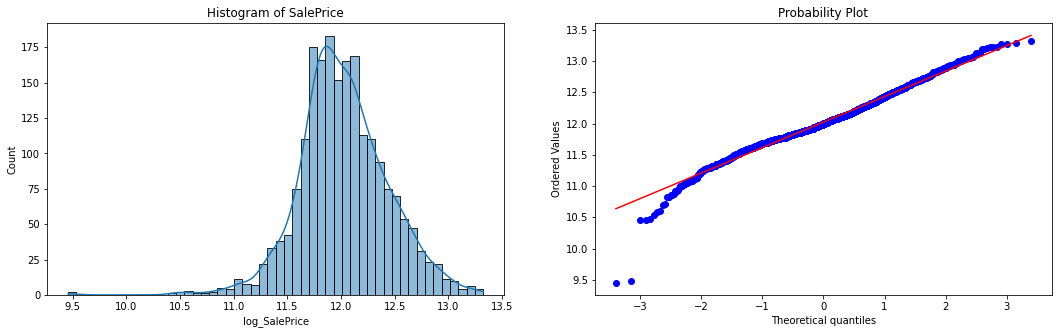

In [6]:
show_hist_qq(df,"log_SalePrice","Histogram of SalePrice")

This looks better.

#### Now let's do a basic comparison between `Gr Liv Area` and `SalePrice`

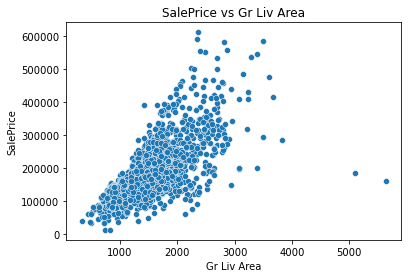

In [7]:
_,=sns.scatterplot(data=df,x="Gr Liv Area",y="SalePrice").set(title="SalePrice vs Gr Liv Area")

We do see a cone shape in the data, which suggests heteroscedasticity.  
Let us look at the logged `SalePrice`.

At this point we do realise there are 2 outliers, let's remove them.

In [8]:
df=df[df['Gr Liv Area']<=4500]
df_copy=df.copy()

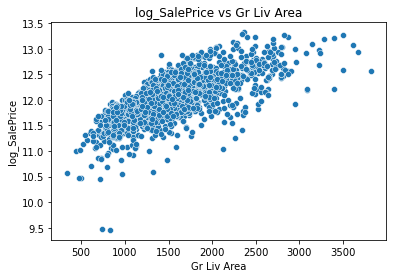

In [9]:
_,=sns.scatterplot(data=df,x="Gr Liv Area",y="log_SalePrice").set(title="log_SalePrice vs Gr Liv Area")

There's another 2 data points at the bottom which looks out of place, let's remove them.

In [10]:
df=df[df['SalePrice']>np.expm1(10)]
df_copy=df.copy()

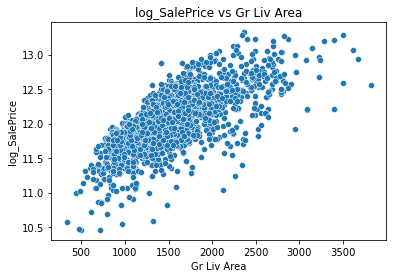

In [11]:
_,=sns.scatterplot(data=df,x="Gr Liv Area",y="log_SalePrice").set(title="log_SalePrice vs Gr Liv Area")

This looks better. The data points do not spread out in a conical shape as previous.  
We'll use a **TransformedTargetRegressor** later to transform `SalePrice` to log.  
More on this later.

Let's look at `Overall Qual` against `log_SalePrice` too

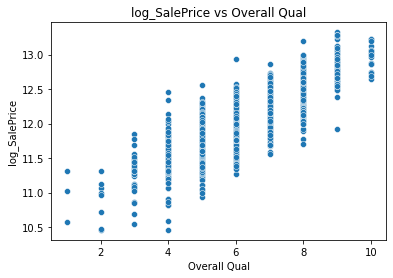

In [12]:
_,=sns.scatterplot(data=df,x="Overall Qual",y="log_SalePrice").set(title="log_SalePrice vs Overall Qual")

There seems to be a strong correlation between `log_SalePrice` and `Overall Qual`

### Preliminary feature selection

#### Let's study the correlation

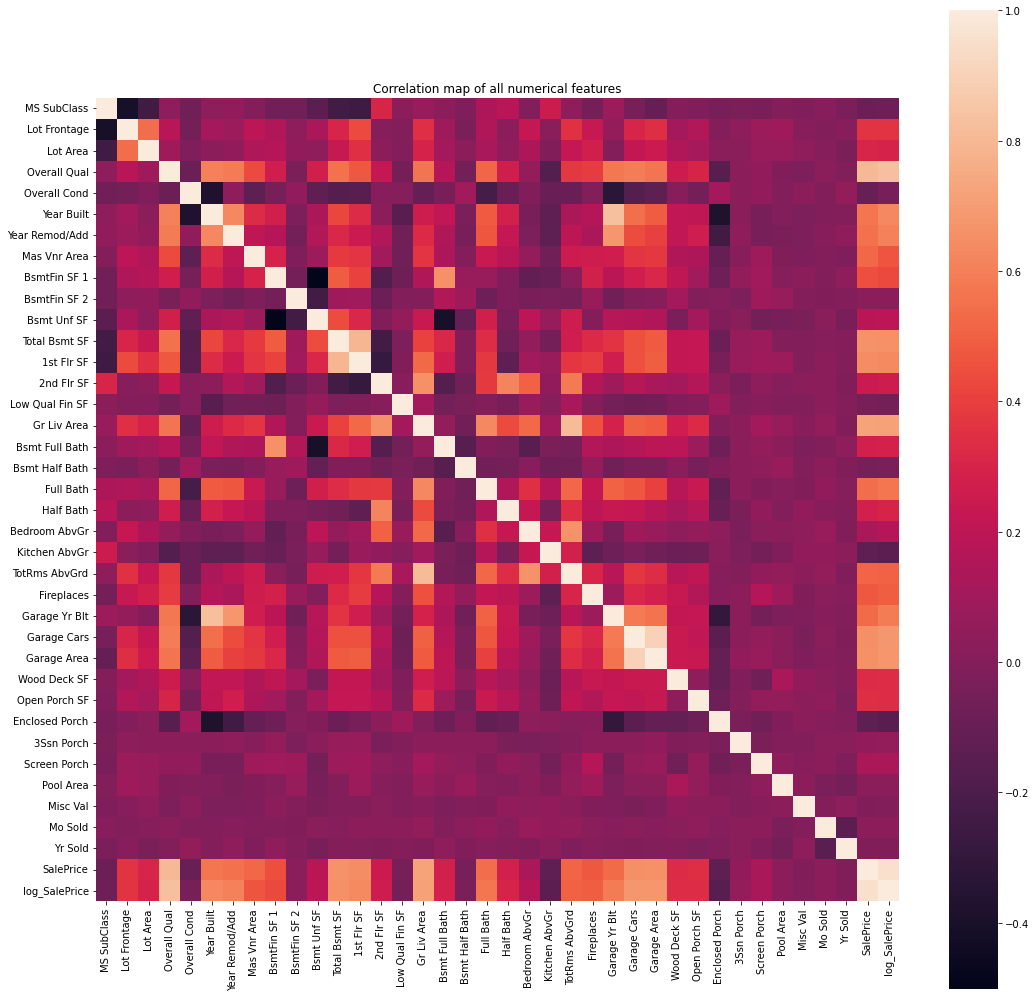

In [13]:
correlation_map(df,title="Correlation map of all numerical features")

We do see a few variables having high correlation with each other. These should not be dropped in the model later.  
`1st Flr SF` and `Total Bsmt SF`  
`Garage Yr Blt` and `Year Built`  
`TotRms AbvGrd` and `Gr Liv Area`  
`Garage Area` and `Garage Cars`

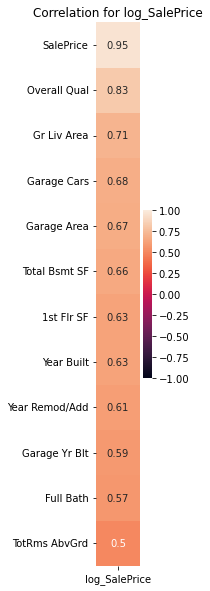

In [14]:
_=single_correlation_map(df,"log_SalePrice")

We do notice the few features with high correlation ($\ge$ 0.5) with `log_SalePrice` being:  
`Overall Qual`,`Gr Liv Area`, `Garage Cars`, `Garage Area`, `Year Built`, `Total Bsmt SF`, `Year Remod/Add`, `1st Flr SF`, `Garage Yr Blt`, `Full Bath`.


However, 3 of the 10 features shall be dropped due to high correlation with other features.  
Namely: `Garage Area`, `Garage Yr Blt`, `1st Flr SF`.  
(We drop the lower correlating one and keep the higher correlating one).

We are left with 7 primary variables:  
`Overall Qual`, `Gr Liv Area`, `Garage Cars`, `Year Built`, `Total Bsmt SF`, `Year Remod/Add`, `Full Bath`.

#### Final list of features and columns to keep.

In [15]:
features_to_keep=['Overall Qual','Gr Liv Area','Garage Cars','Year Built','Total Bsmt SF','Year Remod/Add','Full Bath']
#include the label 'SalePrice' as all columns to keep
cols_to_keep=[*features_to_keep,'SalePrice'] 

### Set up model

In [16]:
#retrieve df_train from backup
df_train=df_copy.copy()

#remove missing data
df_train=df_train.dropna(subset=features_to_keep).reset_index(drop=True)

#set up X and Y
X=df_train.drop(columns="SalePrice")
y=df_train["SalePrice"]

#make a backup copy
X_copy=X.copy()
y_copy=y.copy()

#### Set up a `TransformedTargetRegressor` to handle the log / exponential transformation of the label  
Uses Pipeline to perform preprocessing and prediction

In [17]:
#Create a regressor to dynamically creates a pipeline
def create_regressor(model,**kwargs):
    '''
    model:regressor instance
    return: TransformedTargetRegressor
    '''
    pipeline=Pipeline(steps=[
        ('selector',FeatureSelector(**kwargs)),
        ('model',model)
    ])
        
    return TransformedTargetRegressor(regressor=pipeline,
                                    func=np.log1p,
                                    inverse_func=np.expm1)

#### Try a dummy regressor

In [18]:
X=X_copy.copy()

dummy=create_regressor(DummyRegressor(),feature_names=features_to_keep)

np.sqrt(-cross_val_score(dummy,X,y,cv=5,scoring='neg_mean_squared_error')).mean()

80422.44139371564

#### Try a linear regressor

In [19]:
X=X_copy.copy()

lr=create_regressor(LinearRegression(),feature_names=features_to_keep)

np.sqrt(-cross_val_score(lr,X,y,cv=5,scoring='neg_mean_squared_error')).mean()

27098.56728794601

The linear regressor almost outperform the dummy by 2x.

### Try a submission

In [20]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [21]:
#obtain a copy of the test set
df_test=tester.get_test_df()

In [22]:
#reset the df
X=X_copy.copy()

#instantiate and train the model
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)
lr.fit(X,y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('selector',
                                                      FeatureSelector(feature_names=['Overall '
                                                                                     'Qual',
                                                                                     'Gr '
                                                                                     'Liv '
                                                                                     'Area',
                                                                                     'Garage '
                                                                                     'Cars',
                                                                                     'Year '
                                                                                     'Built',
                                                                                     'Total '
                                                                                     'Bsmt '
                                                                                     'SF',
                                                                                     'Year '
                                                                                     'Remod/Add',
                                                                                     'Full '
                                                                                     'Bath'])),
                                                     ('model',
                                                      LinearRegression())]))

In [23]:
#make prediction
ypred=lr.predict(df_test)

In [24]:
tester.write_submission(ypred,"../data/01_prelim_submission.csv")

Output saved to ../data/01_prelim_submission.csv


**Results**  
Score:25295  
Private score: 25466